In [1]:
!pip install arviz
!pip install pymc3

     |████████████████████████████████| 1.5MB 3.4MB/s 
     |████████████████████████████████| 4.3MB 20.6MB/s 
     |████████████████████████████████| 727kB 35.4MB/s 
     |████████████████████████████████| 296kB 47.2MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [79]:
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns
import math
from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [55]:
#Load and preprocess data

def get_raw_covidtracking_data(url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'):
  """Loads data from source to dataframe"""
  data = pd.read_csv(url)
  return data

def process_covidtracking_data(data: pd.DataFrame):
  """Process raw data before feeding into the generative model"""
  #Set date as index
  data = data.set_index(["location","date"]).sort_index()
  #Remove all columns except 'total_cases', 'total_tests'
  data = data[['total_cases', 'total_tests']]
  #Handle missing values
  data.dropna(subset = ['total_cases', 'total_tests'], inplace = True)
  return data

def get_and_process_covidtracking_data(country = ['Canada']):
    data = get_raw_covidtracking_data()
    data = data[data.location.isin(country)]
    data = process_covidtracking_data(data)
    return data

In [56]:
#EDA
df = get_and_process_covidtracking_data(['India','China'])

In [58]:
df

total_cases  total_tests
location date                                
China    2020-06-24      84653.0   90000000.0
         2020-08-06      88328.0  160000000.0
India    2020-03-13         75.0       6500.0
         2020-03-18        137.0      13125.0
         2020-03-19        165.0      13316.0
...                          ...          ...
         2020-10-11    7053806.0   86877242.0
         2020-10-12    7120538.0   87872093.0
         2020-10-13    7175880.0   88945107.0
         2020-10-14    7239389.0   90090122.0
         2020-10-15    7307097.0   91226305.0

[207 rows x 2 columns]

In [54]:

df.shape


(207, 2)

In [11]:
df[df.location == 'Canada'].isna().mean() *100

iso_code                             0.000000
continent                            0.000000
location                             0.000000
date                                 0.000000
total_cases                          8.934708
new_cases                            0.000000
new_cases_smoothed                   2.061856
total_deaths                        24.054983
new_deaths                           0.000000
new_deaths_smoothed                  2.061856
total_cases_per_million              8.934708
new_cases_per_million                0.000000
new_cases_smoothed_per_million       2.061856
total_deaths_per_million            24.054983
new_deaths_per_million               0.000000
new_deaths_smoothed_per_million      2.061856
new_tests                           33.676976
total_tests                         30.240550
total_tests_per_thousand            30.240550
new_tests_per_thousand              33.676976
new_tests_smoothed                  29.209622
new_tests_smoothed_per_thousand   

In [13]:
df_can = df[df.location == 'Canada']

In [31]:
df_can.shape

(291, 41)

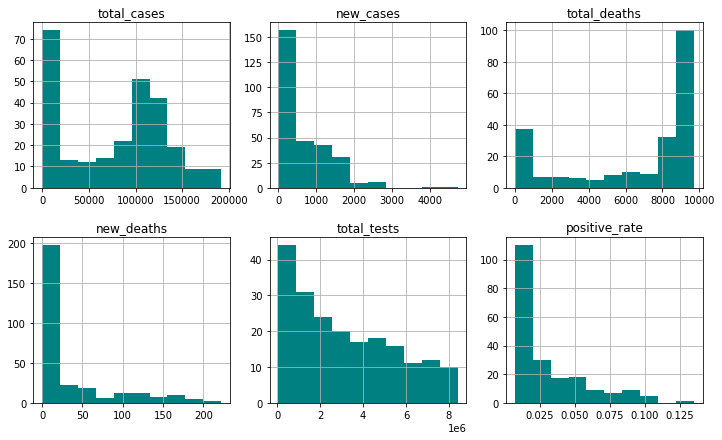

In [17]:
fig = plt.figure(figsize=(12,7))
ncols = 3
nrows = math.ceil(6/ncols)

for i,column in enumerate(['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_tests','positive_rate']):
  ax = fig.add_subplot(nrows, ncols, i + 1)
  ax.set_title(column)
  df_can[column].hist(axes = ax, color = 'teal')
plt.subplots_adjust(hspace = 0.3)

In [22]:
data = get_raw_covidtracking_data("https://covidtracking.com/api/v1/states/daily.csv")
data.head()

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestEncountersViral,totalTestsPeopleViral,totalTestsAntibody,positiveTestsAntibody,negativeTestsAntibody,totalTestsPeopleAntibody,positiveTestsPeopleAntibody,negativeTestsPeopleAntibody,totalTestsPeopleAntigen,positiveTestsPeopleAntigen,totalTestsAntigen,positiveTestsAntigen,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20201015,AK,11348.0,NaN,508113.0,NaN,totalTestsViral,519461.0,60.0,NaN,NaN,NaN,7.0,NaN,6066.0,A,10/15/2020 03:59,2020-10-15T03:59:00Z,10/14 23:59,65.0,NaN,2020-10-15T03:59:00Z,519461.0,10178.0,508970.0,11348.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,165,2119,519461,2284,519461,1,0,be25105ae62bda9a8c21c7821ab39f0ecd847747,0,0,0,0,0,NaN
1,20201015,AL,169162.0,20503.0,1085415.0,NaN,totalTestsViral,1234074.0,844.0,18635.0,NaN,1914.0,NaN,1091.0,74238.0,A,10/15/2020 11:00,2020-10-15T11:00:00Z,10/15 07:00,2756.0,18635.0,2020-10-15T11:00:00Z,1234074.0,NaN,NaN,148659.0,2590.0,166.0,NaN,NaN,NaN,NaN,NaN,60916.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1185,6939,1254577,7853,1254577,50,0,65a2155bebc9bb83509af4218b9d2b9ba7aa19de,0,0,0,0,0,NaN
2,20201015,AR,96524.0,5221.0,1094699.0,NaN,totalTestsViral,1186002.0,587.0,6199.0,236.0,NaN,103.0,760.0,86447.0,A+,10/15/2020 00:00,2020-10-15T00:00:00Z,10/14 20:00,1645.0,6199.0,2020-10-15T00:00:00Z,1186002.0,NaN,1094699.0,91303.0,1494.0,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32741.0,5789.0,21856.0,3300.0,5,1278,11592,1191223,12660,1191223,11,51,9e5ef136e493f90d74a1d610451f2c261f5dcaac,0,0,0,0,0,NaN
3,20201015,AS,0.0,NaN,1616.0,NaN,totalTestsViral,1616.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,10/1/2020 00:00,2020-10-01T00:00:00Z,09/30 20:00,0.0,NaN,2020-10-01T00:00:00Z,1616.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,0,0,1616,0,1616,0,0,dd761d084c96db69d91d8b752bc74edca94e3608,0,0,0,0,0,NaN
4,20201015,AZ,228748.0,5056.0,1377341.0,NaN,totalTestsPeopleViral,1601033.0,726.0,20462.0,173.0,NaN,75.0,NaN,37782.0,A+,10/15/2020 00:00,2020-10-15T00:00:00Z,10/14 20:00,5789.0,20462.0,2020-10-15T00:00:00Z,NaN,NaN,NaN,223692.0,5502.0,287.0,NaN,1601033.0,304875.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1113,10731,1606089,11831,1606089,17,96,bad56e43be843d7fa36f41f5ce020a95d7c4abac,0,0,0,0,0,NaN


In [23]:
data = data.rename(columns={"state": "region"})
data["date"] = pd.to_datetime(data["date"], format="%Y%m%d")
data = data.set_index(["region", "date"]).sort_index()
data = data[["positive", "total"]]

In [25]:
data = data.drop(["MP", "GU", "AS", "PR", "VI"])

In [30]:
idx = pd.IndexSlice
data.loc[idx["MI", pd.Timestamp("2020-06-05") :], "positive"]

region  date      
MI      2020-06-05     64821.0
        2020-06-06     64914.0
        2020-06-07     64969.0
        2020-06-08     65104.0
        2020-06-09     65167.0
                        ...   
        2020-10-11    149464.0
        2020-10-12    151396.0
        2020-10-13    152862.0
        2020-10-14    154455.0
        2020-10-15    156913.0
Name: positive, Length: 133, dtype: float64

In [9]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()

In [19]:
states.head()

state  date      
AK     2020-03-06    0.0
       2020-03-07    0.0
       2020-03-08    0.0
       2020-03-09    0.0
       2020-03-10    0.0
Name: positive, dtype: float64

In [17]:
new_cases = states.diff()

In [18]:
new_cases

state  date      
AK     2020-03-06      NaN
       2020-03-07      0.0
       2020-03-08      0.0
       2020-03-09      0.0
       2020-03-10      0.0
                     ...  
WY     2020-10-14    213.0
       2020-10-15    198.0
       2020-10-16    290.0
       2020-10-17    151.0
       2020-10-18    209.0
Name: positive, Length: 12821, dtype: float64

Main

In [54]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
data = pd.read_csv(url,
                     usecols=['date', 'location', 'total_cases'],
                     parse_dates=['date'],
                     index_col=['location', 'date'],
                     squeeze=True).sort_index()


In [57]:
data.index

MultiIndex([('Afghanistan', '2019-12-31'),
            ('Afghanistan', '2020-01-01'),
            ('Afghanistan', '2020-01-02'),
            ('Afghanistan', '2020-01-03'),
            ('Afghanistan', '2020-01-04'),
            ('Afghanistan', '2020-01-05'),
            ('Afghanistan', '2020-01-06'),
            ('Afghanistan', '2020-01-07'),
            ('Afghanistan', '2020-01-08'),
            ('Afghanistan', '2020-01-09'),
            ...
            (   'Zimbabwe', '2020-10-10'),
            (   'Zimbabwe', '2020-10-11'),
            (   'Zimbabwe', '2020-10-12'),
            (   'Zimbabwe', '2020-10-13'),
            (   'Zimbabwe', '2020-10-14'),
            (   'Zimbabwe', '2020-10-15'),
            (   'Zimbabwe', '2020-10-16'),
            (   'Zimbabwe', '2020-10-17'),
            (   'Zimbabwe', '2020-10-18'),
            (   'Zimbabwe', '2020-10-19')],
           names=['location', 'date'], length=51166)

In [88]:
#Prepare cases

def prepare_cases(cases, cutoff = 25):
  new_cases = cases.diff()

  smoothed = new_cases.rolling(7, win_type = 'gaussian', min_periods = 1, center = True).mean(std = 2).round()
  idx_start = np.searchsorted(smoothed, cutoff)
  smoothed = smoothed.iloc[idx_start:]
  original = new_cases.loc[smoothed.index]

  return original, smoothed

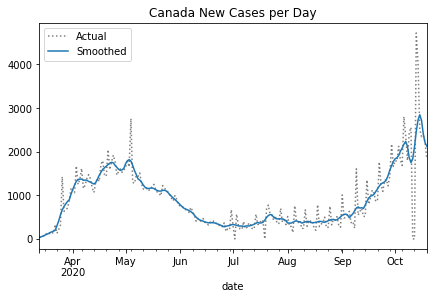

In [89]:
country_name = 'Canada'

cases = data.xs(country_name).rename(f"{country_name} cases")
original, smoothed = prepare_cases(cases)

original.plot(title=f"{country_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
               figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')


In [90]:
GAMMA = 1/7
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
def get_posteriors(sr, sigma = 0.15):
  # Calculate Lambda
  lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

  #Calculate each days likelihood
  likelihoods = pd.DataFrame(data = sps.poisson.pmf(sr[1:], lam),
                             index = r_t_range,
                             columns = sr.index[1:])
  
  # Create Gaussian and normalize
  process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

  process_matrix /= process_matrix.sum(axis=0)

  # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
  prior0 = np.ones_like(r_t_range)/len(r_t_range)
  prior0 /= prior0.sum()

  # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
  posteriors = pd.DataFrame(
      index=r_t_range,
      columns=sr.index,
      data={sr.index[0]: prior0}
    )

  # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
  log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
  for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
      current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
      numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
      denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
      posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
      log_likelihood += np.log(denominator)
    
  return posteriors, log_likelihood




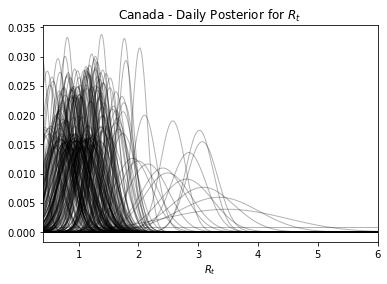

In [91]:
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)


ax = posteriors.plot(title=f'{country_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');



In [92]:
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])


# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
date,,,
2020-10-15,1.38,1.18,1.57
2020-10-16,0.81,0.59,0.99
2020-10-17,0.28,0.05,0.46
2020-10-18,0.37,0.13,0.57
2020-10-19,0.65,0.40,0.85


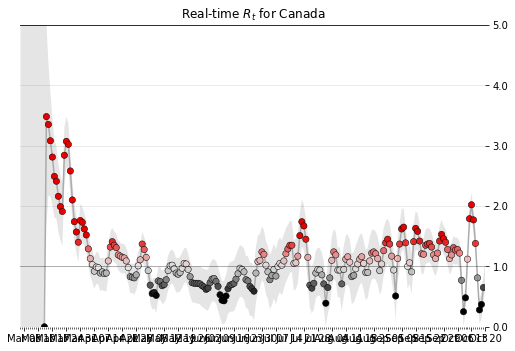

In [93]:
def plot_rt(result, ax, country_name):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, country_name)
ax.set_title(f'Real-time $R_t$ for {country_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))